In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 25
N_CUTS = 10
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('1997-03-14', datetime.date(2022, 3, 14))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


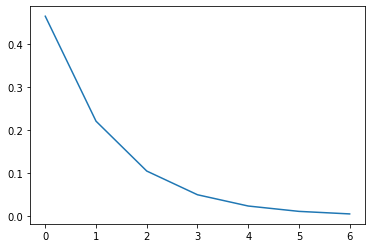

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.2213282028967274

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA',  # NY Stock Exchange (total)
           '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [(first, second) for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
        for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-03-07  17.839527  7.034305  17.839527  7.034305  17.839527  7.034305   
2022-03-08  17.796870  6.958064  17.796870  6.958064  17.796870  6.958064   
2022-03-09  18.763963  7.417718  18.763963  7.417718  18.763963  7.417718   
2022-03-10  18.418532  7.284544  18.418532  7.284544  18.418532  7.284544   
2022-03-11  17.523991  7.002687  17.523991  7.002687  17.523991  7.002687   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-03-07  17.839527  7.034305  17.839527  7.034305  
2022-03-08  17.796870  6.958064  17.796870  6.958064  
2022-03-09  18.763963  7.417718  18.763963  7.417718  
2022-03-10  18.418532  7.284544  18.418532  7.284544  
2022-03-11  17.523991  7.002687  17.523991  7.002687

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                                              Close               \
        ^GSPC        ^IXIC         ^NYA       ^W5000       ^GSPC        ^IXIC   
0  793.169983  1292.969971  4416.649902  7580.930176  793.169983  1292.969971   
1  795.710022  1279.430054  4423.729980  7576.669922  795.710022  1279.430054   
2  789.659973  1269.339966  4392.330078  7517.899902  789.659973  1269.339966   
3  785.770020  1249.290039  4373.189941  7468.569824  785.770020  1249.290039   
4  782.650024  1259.260010  4354.049805  7453.850098  782.650024  1259.260010   

                                   High               ... DayToDayChange  \
          ^NYA       ^W5000       ^GSPC        ^IXIC  ...         ^W5000   
0  4416.649902  7580.930176  796.880005  1303.000000  ...            NaN   
1  4423.729980  7576.669922  796.280029  1292.969971  ...       0.999438   
2  4392.330078  7517.899902  797.179993  1283.010010  ...       0.992243   
3  4373.189941  7468.569824  791.590027  1264.349976  ...       0.993438   
4  4354.049805  7453.850098  786.289978  1262.660034  ...       0.998029   

  OvernightChange LogValue IntradayChange DayToDayChange OvernightChange  \
           ^W5000    mine1          mine1          mine1           mine1   
0             NaN      NaN            NaN            NaN             NaN   
1        0.999438      NaN            NaN            NaN             NaN   
2        0.992243      NaN            NaN            NaN             NaN   
3        0.993438      NaN            NaN            NaN             NaN   
4        0.998029      NaN            NaN            NaN             NaN   

  LogValue IntradayChange DayToDayChange OvernightChange  
     mine2          mine2          mine2           mine2  
0      NaN            NaN            NaN             NaN  
1      NaN            NaN            NaN             NaN  
2      NaN            NaN            NaN             NaN  
3      NaN            NaN            NaN             NaN  
4      NaN            NaN            NaN             NaN  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

6286   2022-03-07
6287   2022-03-08
6288   2022-03-09
6289   2022-03-10
6290   2022-03-11
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                                              Close  \
                 ^GSPC        ^IXIC         ^NYA       ^W5000       ^GSPC   
Date                                                                        
1997-03-14  793.169983  1292.969971  4416.649902  7580.930176  793.169983   
1997-03-17  795.710022  1279.430054  4423.729980  7576.669922  795.710022   
1997-03-18  789.659973  1269.339966  4392.330078  7517.899902  789.659973   
1997-03-19  785.770020  1249.290039  4373.189941  7468.569824  785.770020   
1997-03-20  782.650024  1259.260010  4354.049805  7453.850098  782.650024   

                                                         High               \
                  ^IXIC         ^NYA       ^W5000       ^GSPC        ^IXIC   
Date                                                                         
1997-03-14  1292.969971  4416.649902  7580.930176  796.880005  1303.000000   
1997-03-17  1279.430054  4423.729980  7576.669922  796.280029  1292.969971   
1997-03-18  1269.339966  4392.330078  7517.899902  797.179993  1283.010010   
1997-03-19  1249.290039  4373.189941  7468.569824  791.590027  1264.349976   
1997-03-20  1259.260010  4354.049805  7453.850098  786.289978  1262.660034   

            ... DayToDayChange OvernightChange LogValue IntradayChange  \
            ...         ^W5000          ^W5000    mine1          mine1   
Date        ...                                                          
1997-03-14  ...            NaN             NaN      NaN            NaN   
1997-03-17  ...       0.999438        0.999438      NaN            NaN   
1997-03-18  ...       0.992243        0.992243      NaN            NaN   
1997-03-19  ...       0.993438        0.993438      NaN            NaN   
1997-03-20  ...       0.998029        0.998029      NaN            NaN   

           DayToDayChange OvernightChange LogValue IntradayChange  \
                    mine1           mine1    mine2          mine2   
Date                                                                
1997-03-14            NaN             NaN      NaN            NaN   
1997-03-17            NaN             NaN      NaN            NaN   
1997-03-18            NaN             NaN      NaN            NaN   
1997-03-19            NaN             NaN      NaN            NaN   
1997-03-20            NaN             NaN      NaN            NaN   

           DayToDayChange OvernightChange  
                    mine2           mine2  
Date                                       
1997-03-14            NaN             NaN  
1997-03-17            NaN             NaN  
1997-03-18            NaN             NaN  
1997-03-19            NaN             NaN  
1997-03-20            NaN             NaN  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(f'Unexpected error getting {stock} data. '
              'Initialized as None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best.json', 'w') as f:
        json.dump(best_param_set, f)




----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.607146739705322
Refitting current best...
Current best ma returns: 3.8488244057639034
Fraction Invested: 0.9607454308175882
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 3.8488249888122406
Invested: 0.9607454308175882
New best: 3.8493239547727893
Invested: 0.9607454308175882
Round: 100


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.607146739705322
Refitting current best...
Current best ew_ma returns: 3.8076493461121843
Fraction Invested: 0.9771609152690672
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 3.8076493675566088
Invested: 0.9771609152690672
Round: 100


Beginning rel

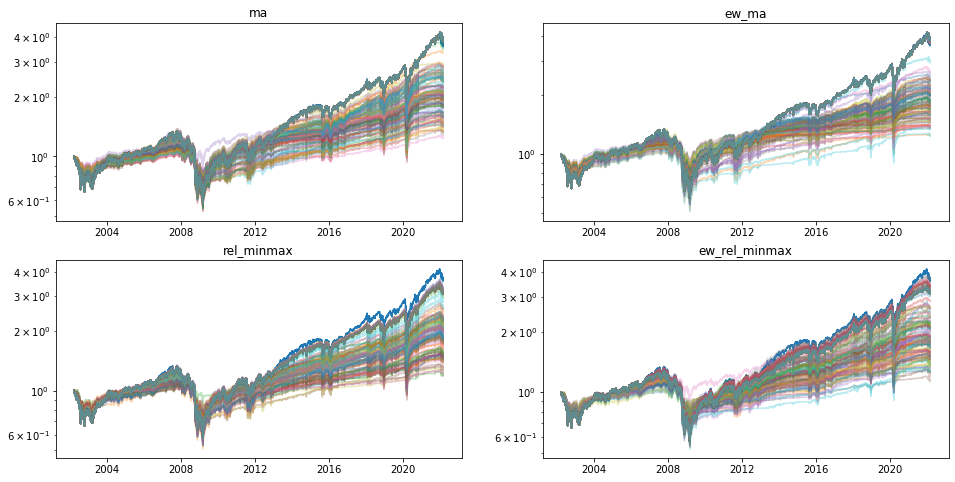

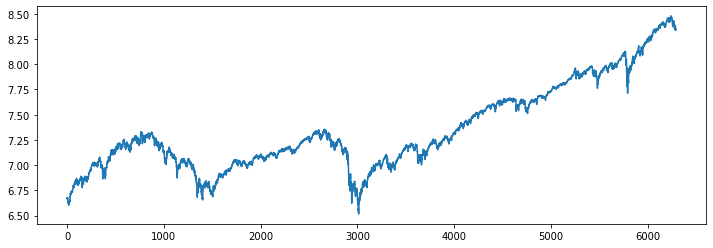

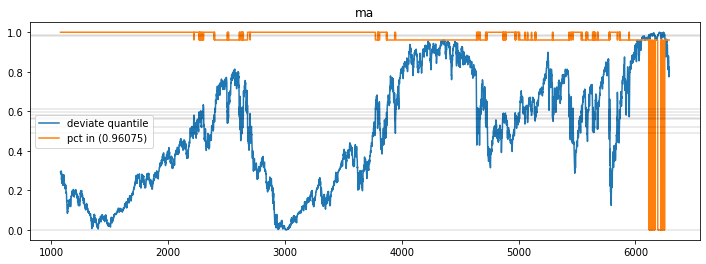

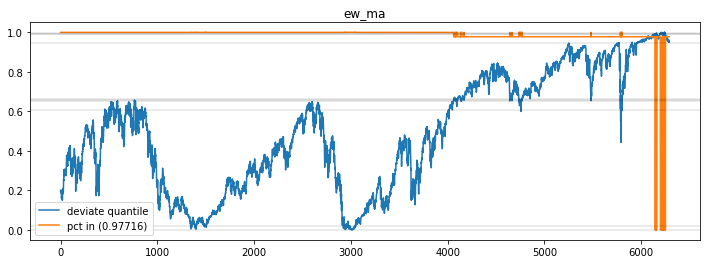

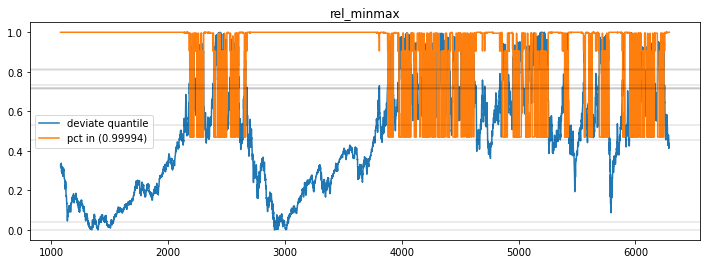

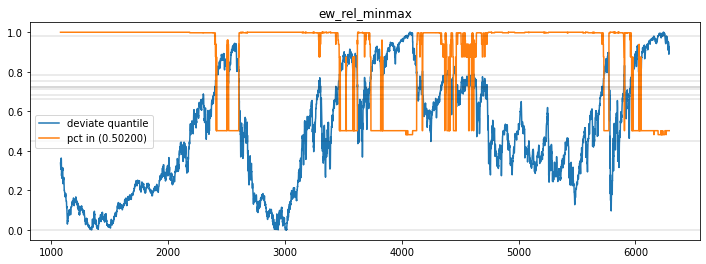

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 6.842513915050105
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 100


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 6.842513915050105
Refitting current best...
Current best ew_ma returns: 8.86348229194185
Fraction Invested: 0.9982041216772393
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 8.863482293017334
Invested: 0.9982041216772393
New best: 8.863955999945544
Invested: 0.9982041216772393
Round: 100


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 6.842513915

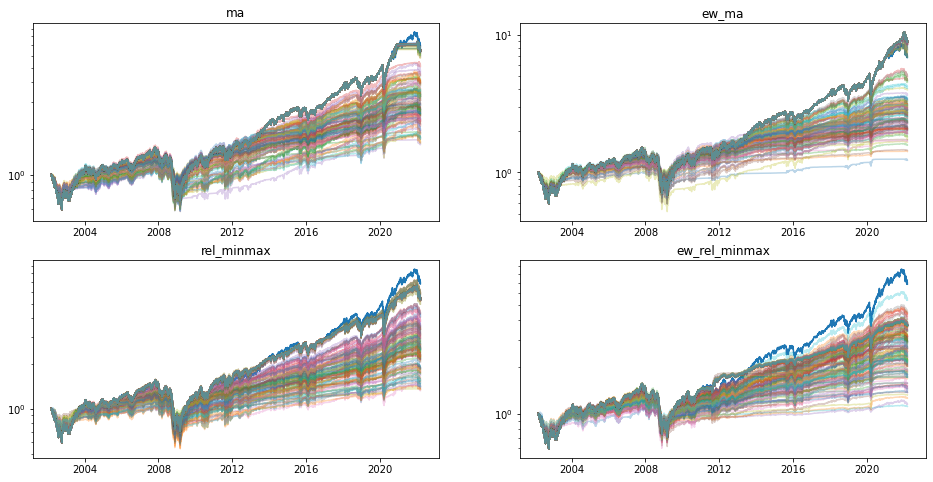

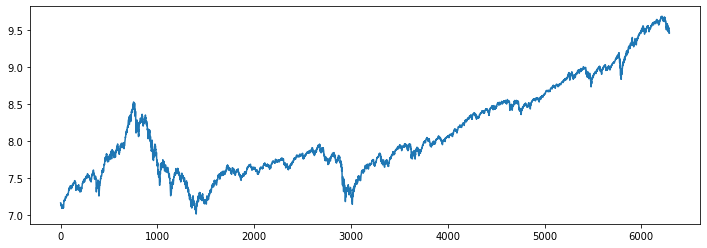

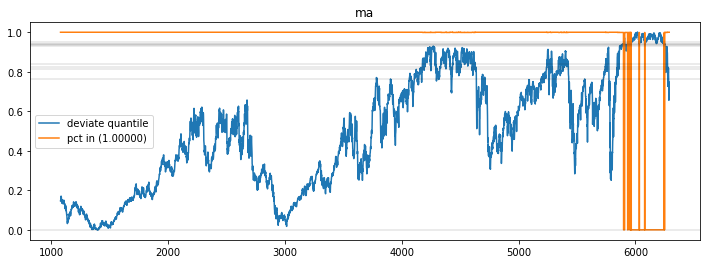

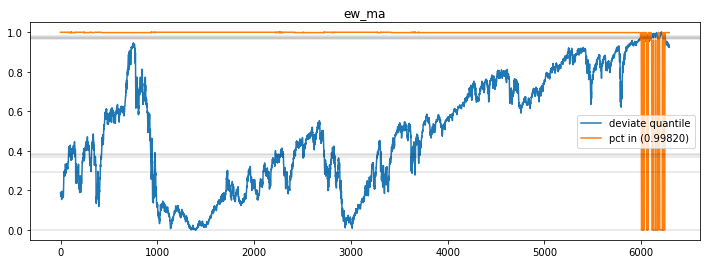

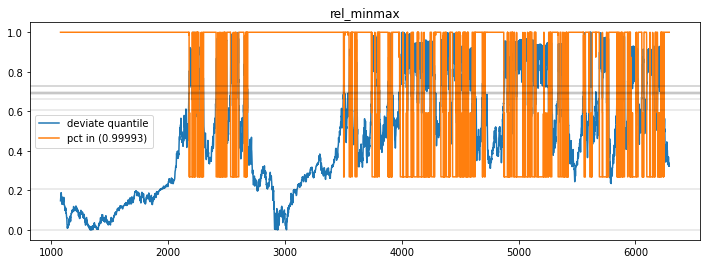

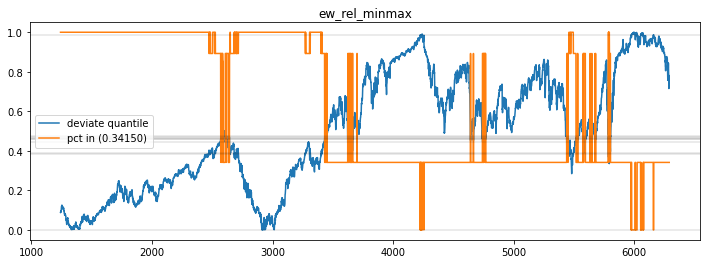

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.4535454514897514
Refitting current best...
Current best ma returns: 3.0982832587711715
Fraction Invested: 0.9999999999999127
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 100


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.4535454514897514
Refitting current best...
Current best ew_ma returns: 3.158391309491514
Fraction Invested: 8.35442929321995e-05
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 3.158602114875012
Invested: 8.35442929321995e-05
New best: 3.15971927687655
Invested: 8.35442929321995e-05
Round: 100


Beginning rel_minmax method...
--------------

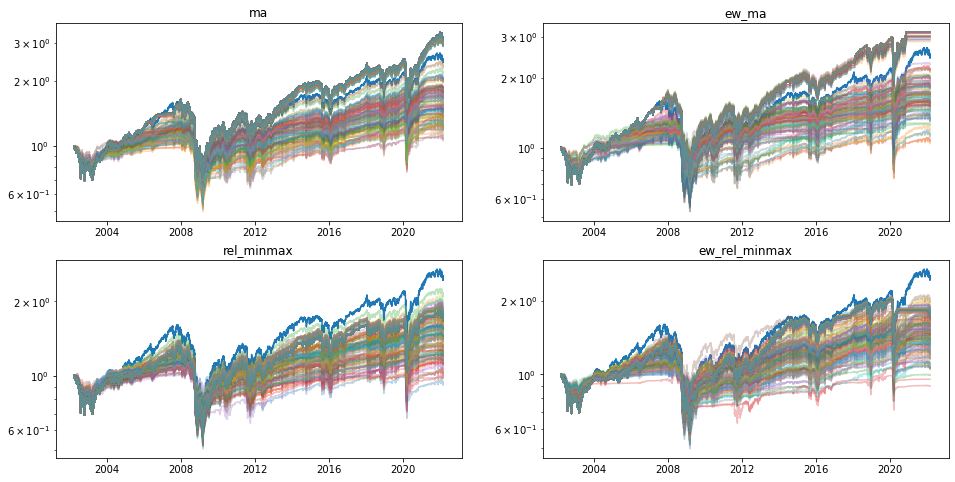

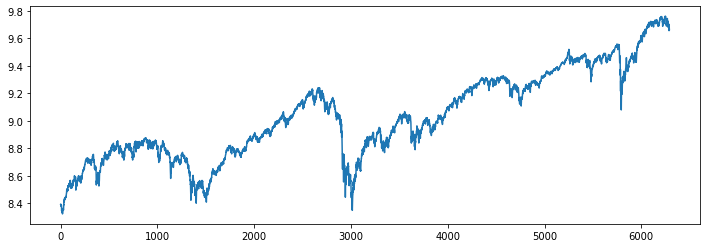

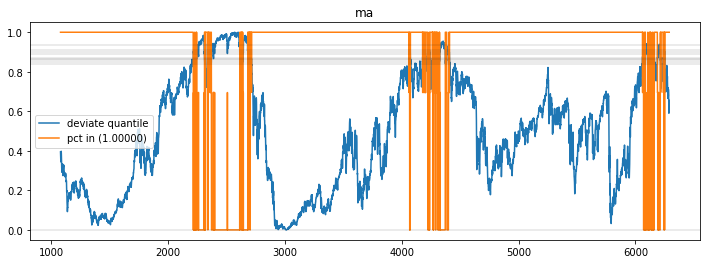

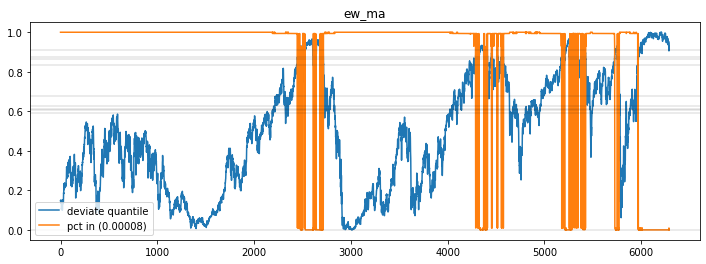

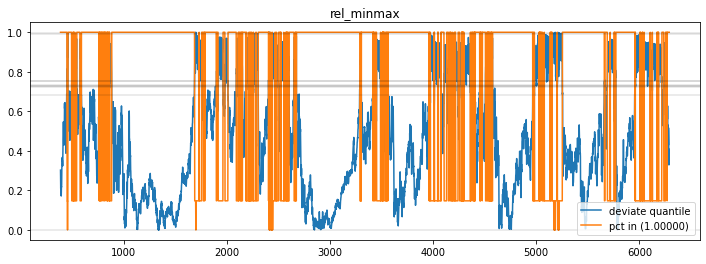

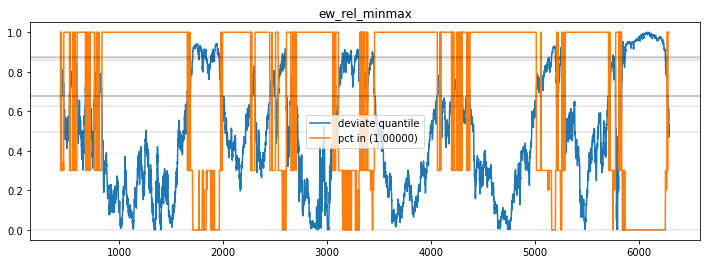

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.8755507127159876
Refitting current best...
Current best ma returns: 4.161222133897684
Fraction Invested: 0.9982955052587241
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 4.161222282924182
Invested: 0.9982955052587241
Round: 100


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.8755507127159876
Refitting current best...
Current best ew_ma returns: 4.311902694346805
Fraction Invested: 0.9957665158951984
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 4.311919882524323
Invested: 0.9957665158951984
Round: 100


Beginning rel_minmax method...
-------------------

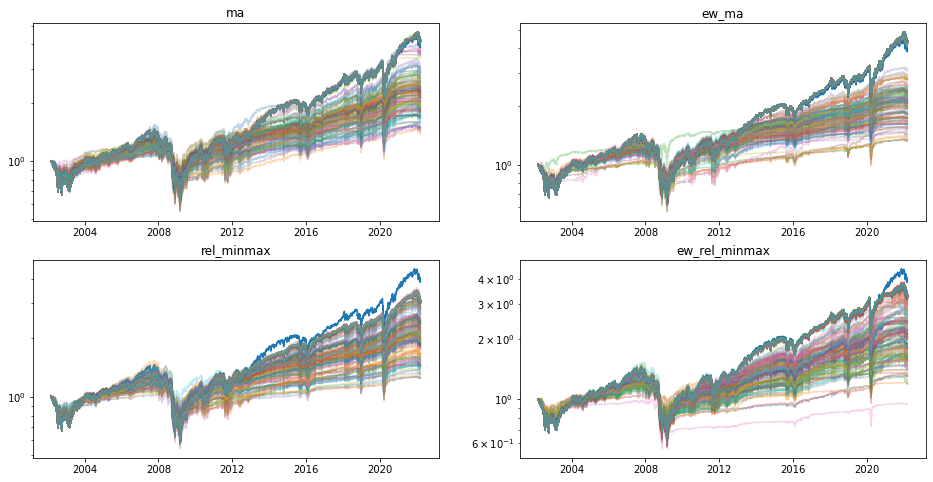

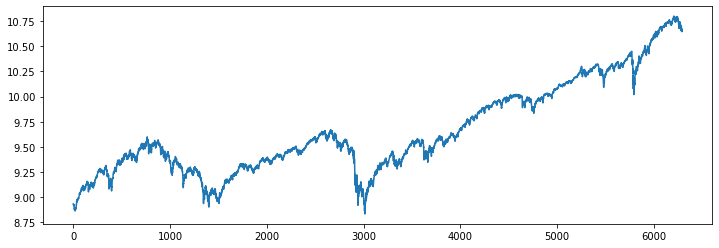

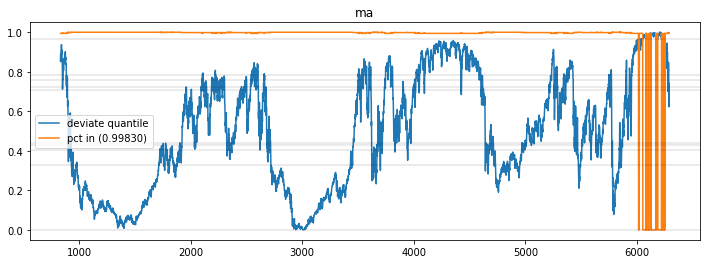

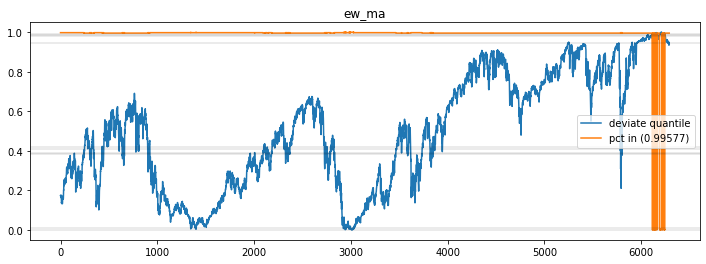

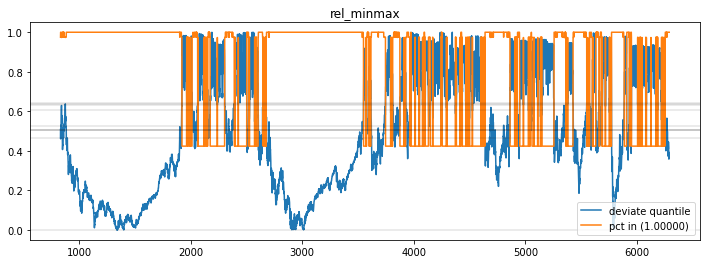

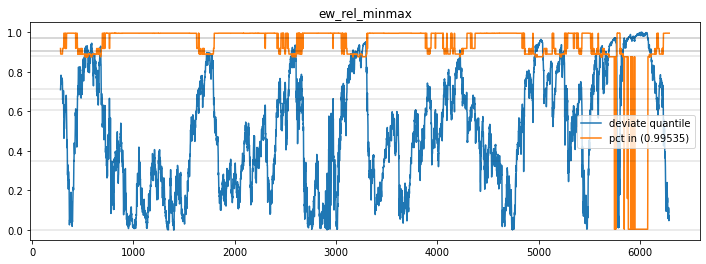

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 11.330455395319227
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 100


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 11.330455395319227
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 100


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 11.330455395319227
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 100


Beginning ew_rel_minmax method...
----

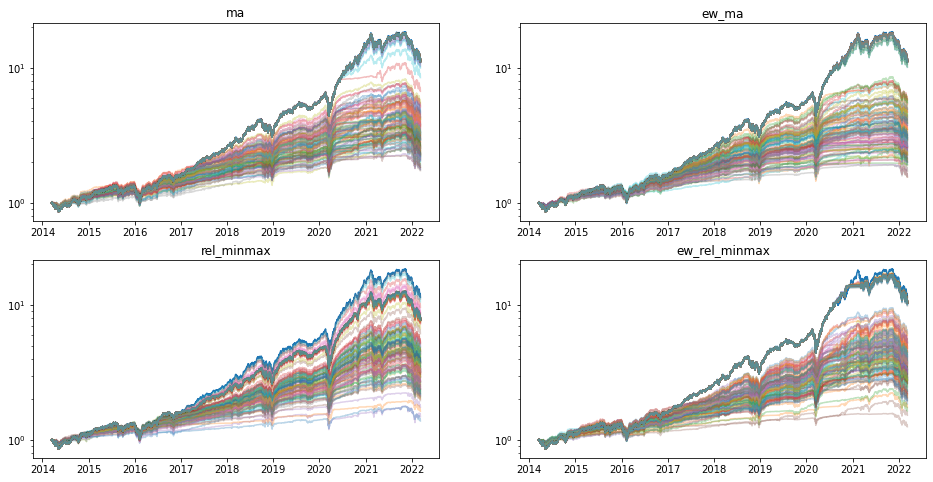

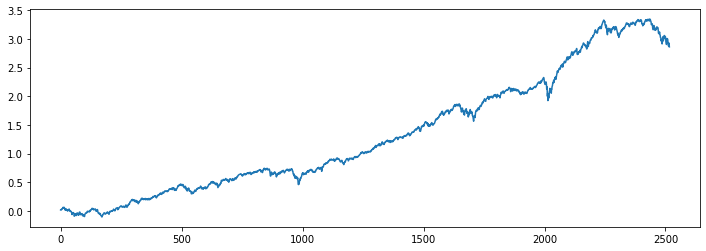

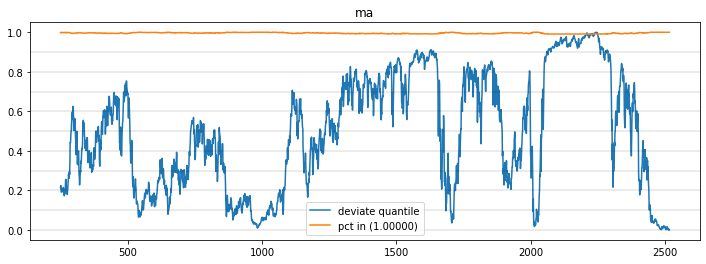

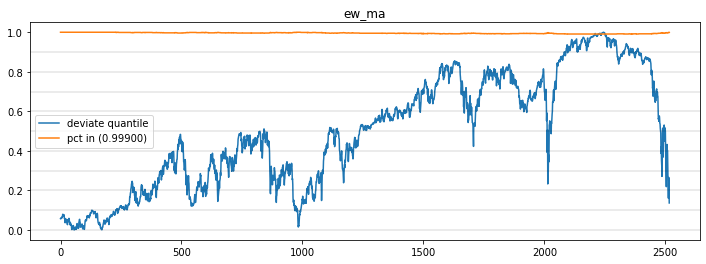

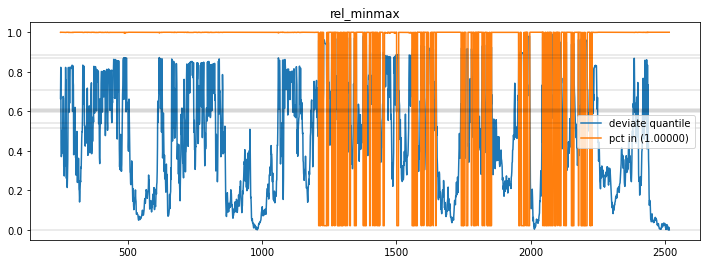

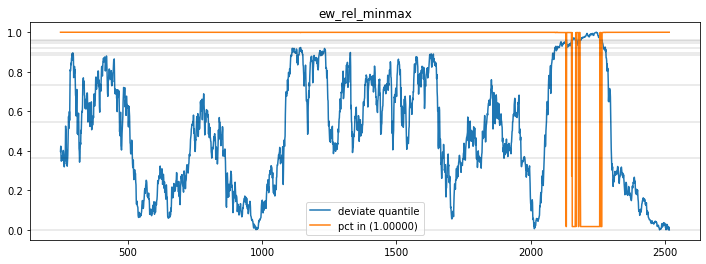

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.4980998125159655
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 100


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 4.4980998125159655
Refitting current best...
Current best ew_ma returns: 6.203235820365808
Fraction Invested: 1.0
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 6.20325190983184
Invested: 1.0
New best: 6.204258308106801
Invested: 1.0
New best: 6.262800860431474
Invested: 1.0
New best: 6.262804743117661
Invested: 1.0
Round: 100


Beginning rel_minmax method...
-----------------------------------------

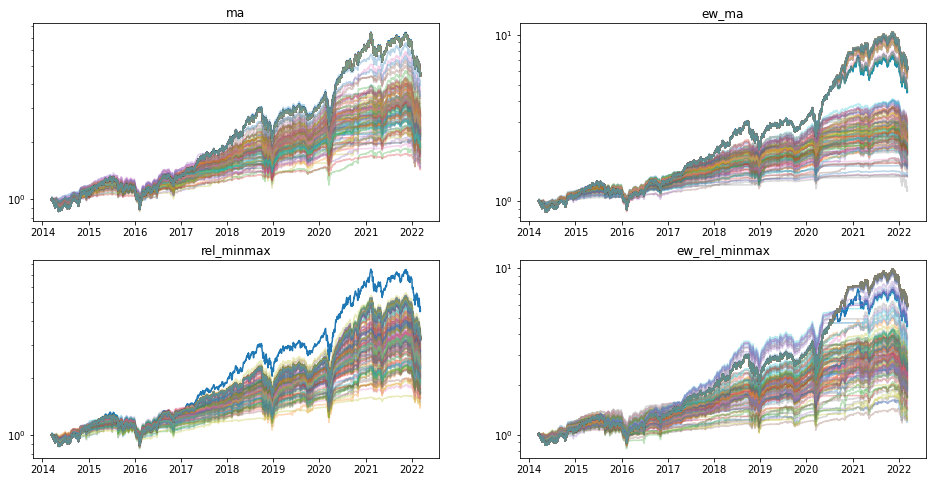

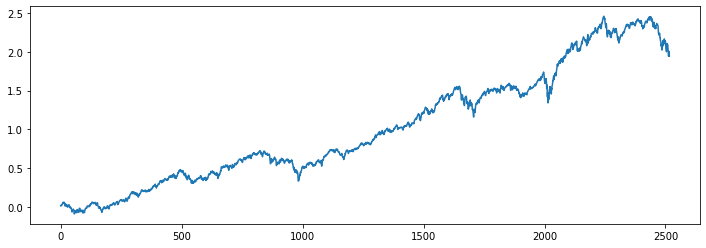

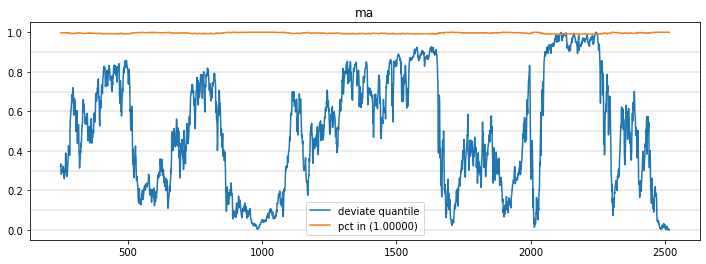

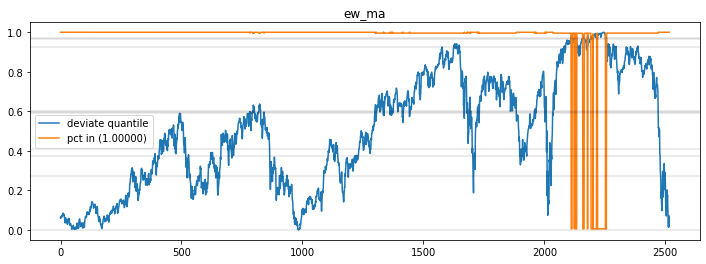

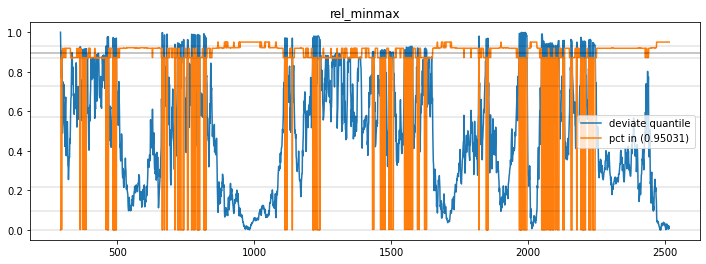

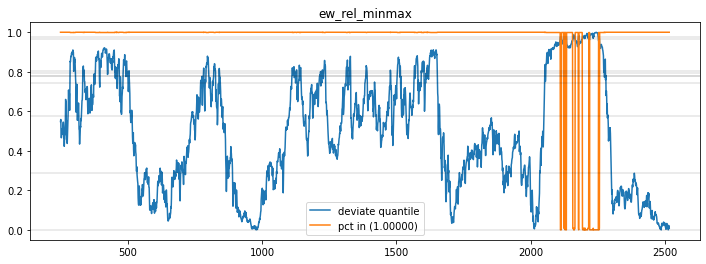

Saving mine2 params...


In [26]:
N_RAND = 100
N_ADJ = 100

do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(stock_data, 
                      N_CUTS, 
                      best_param_set=best_params, 
                      best_returns=best_returns, 
                      sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [27]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = best_return
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [28]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 3.8493239547727893 (ma)
  0.96074543 in
time param: 1079
qs:
(0.0000 - 0.4927): 1.0000
(0.4927 - 0.5185): 1.0000
(0.5185 - 0.5636): 1.0000
(0.5636 - 0.5664): 1.0000
(0.5664 - 0.5798): 0.9999
(0.5798 - 0.5972): 0.9609
(0.5972 - 0.6127): 0.9607
(0.6127 - 0.9826): 0.9607
(0.9826 - 0.9860): 0.0014
(0.9860 - 1.0000): 0.0000

^IXIC:
  Best Return: 8.863955999945544 (ew_ma)
  0.99820412 in
time param: 1079
qs:
(0.0000 - 0.2920): 1.0000
(0.2920 - 0.3692): 1.0000
(0.3692 - 0.3765): 1.0000
(0.3765 - 0.3854): 0.9982
(0.3854 - 0.9654): 0.9982
(0.9654 - 0.9703): 0.9979
(0.9703 - 0.9714): 0.9602
(0.9714 - 0.9777): 0.9602
(0.9777 - 0.9797): 0.0004
(0.9797 - 1.0000): 0.0000

^NYA:
  Best Return: 3.15971927687655 (ew_ma)
  0.00008354 in
time param: 1079
qs:
(0.0000 - 0.5913): 1.0000
(0.5913 - 0.6042): 1.0000
(0.6042 - 0.6133): 0.9940
(0.6133 - 0.6277): 0.9938
(0.6277 - 0.6784): 0.9938
(0.6784 - 0.8364): 0.9935
(0.8364 - 0.8631): 0.9924
(0.8631 - 0.8736): 0.9292
(0.8736 - 0.9092):

{'^GSPC': 3.8493239547727893,
 '^IXIC': 8.863955999945544,
 '^NYA': 3.15971927687655,
 '^W5000': 4.311919882524323,
 'mine1': 11.330455395319227,
 'mine2': 6.262804743117661}

In [29]:
multipliers = {}
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]
    den = do_nothing_returns[stock]
    print(f'{stock}: {num} / {den}')
    multipliers[stock] = num / den
    
multipliers

^GSPC: 3.8493239547727893 / 3.607146739705322
^IXIC: 8.863955999945544 / 6.842513915050105
^NYA: 3.15971927687655 / 2.4535454514897514
^W5000: 4.311919882524323 / 3.8755507127159876
mine1: 11.330455395319227 / 11.330455395319227
mine2: 6.262804743117661 / 4.4980998125159655


{'^GSPC': 1.0671381655760561,
 '^IXIC': 1.2954238909838791,
 '^NYA': 1.2878177068038505,
 '^W5000': 1.1125953966688071,
 'mine1': 1.0,
 'mine2': 1.3923223147897703}

In [30]:
mults = np.array([multipliers[key] for key in batch + ['mine1', 'mine2']])
weights = mults / mults.sum()
weights

array([0.14913959, 0.18104403, 0.17998102, 0.15549254, 0.13975659,
       0.19458622])

In [31]:
!say qp is dunzo